In [21]:
'''
Code adapted from
https://github.com/berkeleydeeprlcourse/homework/blob/master/hw3/dqn.py
'''
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
import gym
import math
import matplotlib.pyplot as plt
from gym.wrappers.monitor import Monitor
import time
import sys
import random
from collections import deque

In [22]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.batch_size = 64
        self.train_start = 1000
        self.render = False
        
        self.memory = deque([], 2000)
        self.score_history = []
        self.model = self.DQNNet()
        self.target_model = self.DQNNet()
        
        self.updateTarget()
        
    def DQNNet(self):
        model = Sequential()
        
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        return model
    
    def updateTarget(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    def getAction(self, state):
        r = np.random.uniform(low=0, high=1)

        if r <= self.epsilon:
            action = random.randrange(self.action_size)
        else:
            actionValues = self.model.predict(state)
            action = np.argmax(actionValues[0])
        return action
                
    def train(self):
        if len(self.memory) < self.train_start:
            return
        
        batch_size = min(self.batch_size, len(self.memory))
        mb = random.sample(self.memory, batch_size)
        
        new = np.zeros((batch_size, self.state_size))
        newTarget = np.zeros((batch_size, self.state_size))
        action = []
        reward = []
        done = []
        
        for i in range(self.batch_size):
            new[i] = mb[i][0]
            action.append(mb[i][1])
            reward.append(mb[i][2])
            newTarget[i] = mb[i][3]
            done.append(mb[i][4])
            
        target = self.model.predict(new)
        target_val = self.target_model.predict(newTarget)
        
        for i in range(self.batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_val[i]))
        
        self.model.fit(new, target, batch_size=self.batch_size, epochs=1, verbose=0)


In [23]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
numEpisodes = 200

In [24]:
scores = []
episodes = []

In [25]:
for e in range(numEpisodes):
    done = False
    score = 0    
    state = env.reset()
    state = np.reshape(state, [1,state_size])
    
    while not done:
        if agent.render:
            env.render()
            
        action = agent.getAction(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        reward = reward if not done or score == 499 else -100
        
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        score += reward
        state = next_state
        
        if done:
            agent.updateTarget()
            
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(e)
            print(e, score)
            
#             if np.mean(scores[-min(10, len(scores)):]) > 490:
#                 sys.exit()

0 23.0
1 33.0
2 9.0
3 28.0
4 59.0
5 25.0
6 16.0
7 26.0
8 10.0
9 38.0
10 24.0
11 23.0
12 17.0
13 44.0
14 41.0
15 37.0
16 62.0
17 67.0
18 14.0
19 44.0
20 26.0
21 67.0
22 93.0
23 64.0
24 34.0
25 44.0
26 37.0
27 12.0
28 12.0
29 11.0
30 11.0
31 9.0
32 9.0
33 13.0
34 30.0
35 31.0
36 23.0
37 79.0
38 21.0
39 52.0
40 40.0
41 94.0
42 27.0
43 18.0
44 22.0
45 18.0
46 17.0
47 19.0
48 19.0
49 14.0
50 17.0
51 30.0
52 19.0
53 45.0
54 120.0
55 79.0
56 83.0
57 85.0
58 219.0
59 115.0
60 134.0
61 137.0
62 148.0
63 210.0
64 139.0
65 135.0
66 156.0
67 334.0
68 267.0
69 241.0
70 245.0
71 275.0
72 237.0
73 191.0
74 420.0
75 305.0
76 306.0
77 230.0
78 366.0
79 239.0
80 263.0
81 178.0
82 277.0
83 332.0
84 197.0
85 300.0
86 410.0
87 500.0
88 196.0
89 402.0
90 331.0
91 167.0
92 126.0
93 352.0
94 500.0
95 212.0
96 149.0
97 467.0
98 271.0
99 325.0
100 336.0
101 415.0
102 273.0
103 147.0
104 478.0
105 203.0
106 466.0
107 192.0
108 195.0
109 342.0
110 405.0
111 312.0
112 349.0
113 500.0
114 199.0
115 343.0
116 400.0


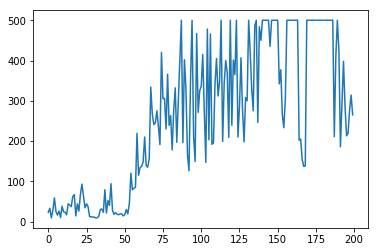

In [26]:
plt.plot(episodes, scores)